In [27]:
import json
import re

In [28]:
def post_processing(judge_text):
    # typo lol
    # judge_text = judge_text.replace("</verduct>", "</verdict>")
    # judge_text = judge_text.replace("</verddict>", "</verdict>")
    judge_text = judge_text.replace("<Verdict>", "<verdict>")
    judge_text = judge_text.replace("</Verdict>", "</verdict>")
    # judge_text = judge_text.replace("<verdict>B</verdict>", "<verdict>[[B]]</verdict>")
    # judge_text = judge_text.replace("Verdict: [[A]] </verdict>", "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('<victory> [[A]] </victory>', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('</verdict> [[B]] </verdict>', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]"', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('"verdict": [["A"]]', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('"verdict": "[[B]]"', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]" "/verdict"', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('"verdict": [[A]]', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('```verdict\n[[B]]\n```', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('{"verdict"} [[B]] {"verdict"}', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('"verdict":"[[B]]"', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('</verdict> [[A]] </verdict>', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict":"[[A]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"`verdict`: [[B]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('{"verdict": "B"}', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('Audio A performs better than Audio B', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict": [[B]]', "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('Based on the analysis, Audio A demonstrates superior pronunciation clarity and accuracy compared to Audio B', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict" [[B]] </verdict>', "<verdict> [[B]] </verdict>")


    judge_text = judge_text.replace('{"verdict"} [[A]] {"verdict"}', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('{verdict} [[A]] {verdict}', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('[verdict] [[A]] [/verdict]', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('/verdict": "[[B]]}"', "<verdict> [[B]] </verdict>")
    # judge_text = judge_text.replace("\verdict\ [[A]] \verdict\\", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('{"Verdict": "[[B]]"}', "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('{"verdict" "[[B]]" "verdict"}', "<verdict> [[B]] </verdict>")
    # judge_text = judge_text.replace('', "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('Verdict: [[A]]', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('Verdict: [[A]]', "<verdict> [[A]] </verdict>")

    judge_text = judge_text.replace('<verdict> [[Neither]] </verdict>', "<verdict> [[C]] </verdict>")
    judge_text = judge_text.replace('<verdict> [[N/A]] </verdict>', "<verdict> [[C]] </verdict>")
    judge_text = judge_text.replace('<verdict> [[Cannot Determine]] </verdict>', "<verdict> [[C]] </verdict>")
    judge_text = judge_text.replace('<verdict> [[Insufficient Data]] </verdict>', "<verdict> [[C]] </verdict>")
    
    return judge_text

In [29]:
def read_output_file(path, reverse=False):
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    
    count_all, count_correct = 0, 0
    predictions = []
    error = 0
    for output in outputs:
        if not reverse:
            audio_a, audio_b = output['data']
        else:
            audio_b, audio_a = output['data']

        judge_text = output['response']
        judge_text = post_processing(judge_text)
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]" or verdict_text == "[[C]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            # print("warning:", judge_text)
            # if audio_a['Q'] > audio_b['Q']: verdict_text = '[[B]]'
            # else: verdict_text = '[[A]]'
            verdict_text = '[[C]]'
            error += 1
            
        if verdict_text == "[[A]]":
            if audio_a['Q'] > audio_b['Q']:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
        elif verdict_text == "[[B]]":
            if audio_a['Q'] < audio_b['Q']:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
        elif verdict_text == "[[C]]":
            evaluation = "incorrect"
                
        count_all += 1
        predictions.append([evaluation, verdict_text, audio_a['Q'], audio_b['Q']])
    print("total:", count_all)
    print("error: {:.2f}%".format(error/count_all*100))
    print("accuracy: {:.2f}%".format(count_correct/count_all*100))
    return predictions

In [34]:
predictions_ab = read_output_file(f"../experiments/tmhintqi/ab_testing/shuffled_gemini5flash_prompt2.jsonl")

total: 6475
error: 0.79%
accuracy: 59.83%


In [35]:
predictions_ba = read_output_file(f"../experiments/tmhintqi/ab_testing/shuffled_gemini5flash_prompt2_BA.jsonl", reverse=True)

total: 6475
error: 0.86%
accuracy: 60.05%


In [36]:
abba_correct, abba_incorrect = 0, 0
for x in predictions_ab + predictions_ba:
    if x[0] == 'correct':
        abba_correct += 1
    elif x[0] == 'incorrect':
        abba_incorrect += 1
    else:
        raise Exception()
print("total:", abba_correct+abba_incorrect)
print("correct: {:.2f}%".format(abba_correct/(abba_correct+abba_incorrect)*100))
print("incorrect: {:.2f}%".format(abba_incorrect/(abba_correct+abba_incorrect)*100))

total: 12950
correct: 59.94%
incorrect: 40.06%


In [39]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ab:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    elif x[1] == "[[C]]":
        pass
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 17.87%
percentage_B: 76.34%


In [40]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ba:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    elif x[1] == "[[C]]":
        pass
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 18.05%
percentage_B: 76.12%


In [42]:
predictions_ab = predictions_ab[:len(predictions_ba)]
consistent, bias_A, bias_B = 0, 0, 0
correct_given_consistent = 0
for ab, ba in zip(predictions_ab, predictions_ba):
    if ab[0] == ba[0]:
        consistent += 1
        if ab[0] == 'correct':
            correct_given_consistent += 1
    else:
        if ab[1] == "[[A]]" and ba[1] == "[[A]]":
            bias_A += 1
        elif ab[1] == "[[B]]" and ba[1] == "[[B]]":
            bias_B += 1
        elif ab[1] == "[[C]]" or ba[1] == "[[C]]":
            pass
        else:
            raise Exception("logic error")
# assert consistent + bias_A + bias_B == len(predictions_ab)

In [43]:
print("consistent: {:.2f}%".format(consistent/len(predictions_ab)*100))
print("bias_A:     {:.2f}%".format(bias_A/len(predictions_ab)*100))
print("bias_B:     {:.2f}%".format(bias_B/len(predictions_ab)*100))
print("P(correct|consistent): {:.2f}%".format(correct_given_consistent/consistent*100))

consistent: 37.67%
bias_A:     0.46%
bias_B:     54.58%
P(correct|consistent): 76.38%


# System-level Correlation

In [44]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [45]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, _ = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('MOS (GT)')
    plt.ylabel('AudioJudge Prediction (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

In [61]:

def evaluate_system_level():
    pred_by_system, gts_by_system = {}, {}
    
    reverse = False
    path = f"../experiments/tmhintqi/ab_testing/shuffled_gemini5flash_prompt2.jsonl"
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    for output in outputs:
        audio_a, audio_b = output['data']
        model_a = audio_a['system']
        model_b = audio_b['system']
        if model_a not in pred_by_system: pred_by_system[model_a] = []
        if model_a not in gts_by_system:  gts_by_system[model_a] = []
        if model_b not in pred_by_system: pred_by_system[model_b] = []
        if model_b not in gts_by_system:  gts_by_system[model_b] = []
            
        judge_text = output['response']
        judge_text = post_processing(judge_text)
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            # print("warning:", judge_text)
            # if audio_a['Q'] > audio_b['Q']: verdict_text = '[[B]]'
            # else: verdict_text = '[[A]]'
            verdict_text == "[[C]]"
            
        if verdict_text == "[[A]]":
            pred_by_system[model_a] += [1]
            pred_by_system[model_b] += [0]
        elif verdict_text == "[[B]]":
            pred_by_system[model_a] += [0]
            pred_by_system[model_b] += [1]
        else:
            pred_by_system[model_a] += [0.5]
            pred_by_system[model_b] += [0.5]
    
        gts_by_system[model_a] += [audio_a['Q']]
        gts_by_system[model_b] += [audio_b['Q']]
    
    reverse = True
    path = f"../experiments/tmhintqi/ab_testing/shuffled_gemini5flash_prompt2_BA.jsonl"
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    for output in outputs:
        audio_b, audio_a = output['data']
        model_a = audio_a['system']
        model_b = audio_b['system']
        
        judge_text = output['response']
        judge_text = post_processing(judge_text)
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            # print("warning:", judge_text)
            # if audio_a['Q'] > audio_b['Q']: verdict_text = '[[B]]'
            # else: verdict_text = '[[A]]'
            verdict_text == "[[C]]"
            
        if verdict_text == "[[A]]":
            pred_by_system[model_a] += [1]
            pred_by_system[model_b] += [0]
        elif verdict_text == "[[B]]":
            pred_by_system[model_a] += [0]
            pred_by_system[model_b] += [1]
        else:
            pred_by_system[model_a] += [0.5]
            pred_by_system[model_b] += [0.5]
            
        gts_by_system[model_a] += [audio_a['Q']]
        gts_by_system[model_b] += [audio_b['Q']]
    
    system_level_pred, system_level_gts = [], []
    systems = []
    for system, pred in pred_by_system.items():
        gts = gts_by_system[system]
        assert len(pred) == len(gts)
        system_level_pred.append(np.mean(pred)*100)
        system_level_gts.append(np.mean(gts))
        systems.append(system)
    analyze_correlation_and_plot(system_level_gts, system_level_pred)

Pearson Correlation: 0.770
Spearman Correlation: 0.744


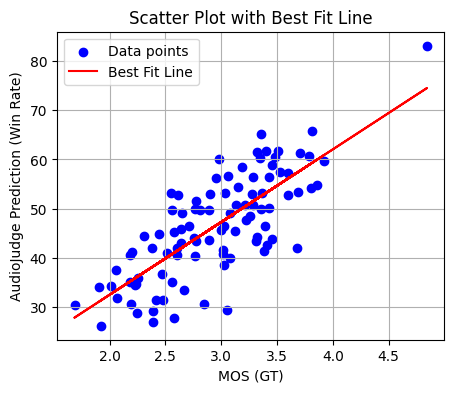

In [63]:
evaluate_system_level()